In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sympy as sym
import matplotlib.lines as mlines

First we establish the thermodynamic data required, including:
* Gas constant (R)
* Enthalpy of formation for $NH_3$ at standard conditions ($\Delta H_{f, NH_3}^o$) 
* Standard entropies of components ($S_{N_2}^o$, $S_{H_2}^o$, $S_{NH_3}^o$)
* Specific Heat Capacity Coefficients (A, B, C, D, E)

In [2]:
#Thermo Data

#Universal Gas Constant 
R = 8.314 # J/(mol K)

#Enthalpy of formation NH3 (standard cond.)
delta_hf_nh3 = -45.94 * 1000

# Standard Entropies
s_n2 = 191.609 #J/mol
s_h2 = 130.680 #J/mol
s_nh3 = 192.77 #J/mol

#Heat Capacity Coefficients
C_P = pd.DataFrame(
    [[19.99563, 49.77119, -15.37599, 1.921168, 0.189174],
     [33.066178, -11.363417, 11.432816, -2.772874, -0.158558],
     [28.98641, 1.853978, -9.647459, 16.63537, 0.000117],
     [19.50583, 19.88705, -8.598535, 1.369784, 0.527601	]]
).transpose()

C_P.index = ["A", "B", "C", "D", "E"]
C_P.columns = ["NH3", "H2", "N2_1", "N2_2"]

Creating an expression for $C_P$:  
$C_P=A+Bt+Ct^2+Dt^3+\frac{E}{t^2}$, where $t=\frac{T}{1000}$

In [3]:
# CP Expression
A_, B_, C_, D_, E_, T_, Ti, Tf = sym.symbols("A, B, C, D, E, T, Ti Tf")
C_P_ = A_ + B_*(T_/1000) + C_*(T_/1000)**2 + D_*(T_/1000)**3 + E_*(T_/1000)**-2
C_P_

A + B*T/1000 + C*T**2/1000000 + D*T**3/1000000000 + 1000000*E/T**2

Then we find the expressions for the sensible enthalpy changes for each component using 
$\Delta H_{i,sens} = A+\frac{BT}{1000}+\frac{CT^2}{10^6}+\frac{DT^3}{10^9}+\frac{10^6\cdot E}{T^2}$

In [4]:
# General Expression for Sensible Enthalpy Change
delta_h_sens = sym.integrate(C_P_, (T_,Ti,Tf))

# Calculate Enthalpy Changes for 1 mole of each component
nh3_enth_sens = delta_h_sens.subs(
    [(A_,C_P.loc["A", "NH3"]), (B_, C_P.loc["B","NH3"]), (C_, C_P.loc["C","NH3"]), (D_, C_P.loc["D","NH3"]),(E_,C_P.loc["E","NH3"]), (Ti,298)]
)

h2_enth_sens = delta_h_sens.subs(
    [(A_,C_P.loc["A","H2"]), (B_, C_P.loc["B","H2"]), (C_, C_P.loc["C","H2"]), (D_, C_P.loc["D","H2"]),(E_,C_P.loc["E","H2"]), (Ti,298)]
)

n2_enth_sens_1 = delta_h_sens.subs(
    [(A_,C_P.loc["A","N2_1"]), (B_, C_P.loc["B","N2_1"]), (C_, C_P.loc["C","N2_1"]), (D_, C_P.loc["D","N2_1"]),(E_,C_P.loc["E","N2_1"]), (Ti,298)]
)

n2_enth_sens_2 = delta_h_sens.subs(
    [(A_,C_P.loc["A","N2_1"]), (B_, C_P.loc["B","N2_1"]), (C_, C_P.loc["C","N2_1"]), (D_, C_P.loc["D","N2_1"]),(E_,C_P.loc["E","N2_1"]), (Ti,298), (Tf,500)]
) + delta_h_sens.subs(
    [(A_,C_P.loc["A","N2_2"]), (B_, C_P.loc["B","N2_2"]), (C_, C_P.loc["C","N2_2"]), (D_, C_P.loc["D","N2_2"]),(E_,C_P.loc["E","N2_2"]), (Ti,500)]
)

Then we find the overall $\Delta H_{rxn}$ in stochiometric ratios for both temperatures upto and from 500 K

In [5]:
# Calculate enthalpy changes

delta_h1 = 2 * delta_hf_nh3
delta_h2 = 2 * nh3_enth_sens

delta_h3_1 = n2_enth_sens_1 + 3*h2_enth_sens
delta_h3_2 = n2_enth_sens_2 + 3*h2_enth_sens

delta_h_rxn_1 = delta_h1 + delta_h2 - delta_h3_1
delta_h_rxn_2 = delta_h1 + delta_h2 - delta_h3_2

print(f"Delta H_rxn (<=500K): {delta_h_rxn_1}")
print(f"Delta H_rxn (>500K):{delta_h_rxn_2}")

Delta H_rxn (<=500K): -1.118603e-9*Tf**4 - 1.84676563333333e-5*Tf**3 + 0.0658893265*Tf**2 - 88.193684*Tf - 68086.5229044564 - 853905.0/Tf
Delta H_rxn (>500K):2.6977935e-9*Tf**4 - 1.88172976666667e-5*Tf**3 + 0.0568727905*Tf**2 - 78.713104*Tf - 71822.4665190398 - 326421.0/Tf


Then we calculate the sensible entropy changes using $\Delta S_i = \int \frac{C_{P,i}}{T} dT$

In [6]:
# Calculate entropy changes
delta_s_sens = sym.integrate(C_P_/T_, (T_,Ti,Tf))

nh3_entr_sens = delta_s_sens.subs(
    [(A_,C_P.loc["A", "NH3"]), (B_, C_P.loc["B","NH3"]), (C_, C_P.loc["C","NH3"]), (D_, C_P.loc["D","NH3"]),(E_,C_P.loc["E","NH3"]), (Ti,298)]
)

h2_entr_sens = delta_s_sens.subs(
    [(A_,C_P.loc["A","H2"]), (B_, C_P.loc["B","H2"]), (C_, C_P.loc["C","H2"]), (D_, C_P.loc["D","H2"]),(E_,C_P.loc["E","H2"]), (Ti,298)]
)

n2_entr_sens_1 = delta_s_sens.subs(
    [(A_,C_P.loc["A","N2_1"]), (B_, C_P.loc["B","N2_1"]), (C_, C_P.loc["C","N2_1"]), (D_, C_P.loc["D","N2_1"]),(E_,C_P.loc["E","N2_1"]), (Ti,298)]
)

n2_entr_sens_2 = delta_s_sens.subs(
    [(A_,C_P.loc["A","N2_1"]), (B_, C_P.loc["B","N2_1"]), (C_, C_P.loc["C","N2_1"]), (D_, C_P.loc["D","N2_1"]),(E_,C_P.loc["E","N2_1"]), (Ti,298), (Tf,500)]
) + delta_s_sens.subs(
    [(A_,C_P.loc["A","N2_2"]), (B_, C_P.loc["B","N2_2"]), (C_, C_P.loc["C","N2_2"]), (D_, C_P.loc["D","N2_2"]),(E_,C_P.loc["E","N2_2"]), (Ti,500)]
)

Once again adding in stochiometric ratios

In [7]:
delta_s1 = 2 * s_nh3-s_n2 - 3 * s_h2
delta_s2 = 2 * nh3_entr_sens

delta_s3_1 = n2_entr_sens_1 + 3 * h2_entr_sens
delta_s3_2 = n2_entr_sens_2 + 3*h2_entr_sens

delta_s_rxn_1 = delta_s1 + delta_s2 - delta_s3_1
delta_s_rxn_2 = delta_s1 + delta_s2 - delta_s3_2

print(f"Delta S_rxn (<=500K): {delta_s_rxn_1}")
print(f"Delta S_rxn (>500K):{delta_s_rxn_2}")

Delta S_rxn (<=500K): -1.49147066666667e-9*Tf**3 - 2.77014845e-5*Tf**2 + 0.131778653*Tf - 88.193684*log(Tf) - 230.071759212497 + 88.193684*log(298) - 426952.5/Tf**2
Delta S_rxn (>500K):3.597058e-9*Tf**3 - 2.82259465e-5*Tf**2 + 0.113745581*Tf - 78.713104*log(Tf) - 222.615141795831 - 9.48058*log(500) + 88.193684*log(298) - 163210.5/Tf**2


Finding expression for Gibbs Free Energy Change for upto and from 500K

In [8]:
# Calculate Gibbs Free Energy changes

delta_g_rxn_1 = delta_h_rxn_1 - Tf*delta_s_rxn_1
delta_g_rxn_2 = delta_h_rxn_2 - Tf*delta_s_rxn_2

print(f"Delta G_rxn (<=500K): {delta_g_rxn_1}")
print(f"Delta G_rxn (>500K):{delta_g_rxn_2}")

Delta G_rxn (<=500K): -1.118603e-9*Tf**4 - 1.84676563333333e-5*Tf**3 + 0.0658893265*Tf**2 - Tf*(-1.49147066666667e-9*Tf**3 - 2.77014845e-5*Tf**2 + 0.131778653*Tf - 88.193684*log(Tf) - 230.071759212497 + 88.193684*log(298) - 426952.5/Tf**2) - 88.193684*Tf - 68086.5229044564 - 853905.0/Tf
Delta G_rxn (>500K):2.6977935e-9*Tf**4 - 1.88172976666667e-5*Tf**3 + 0.0568727905*Tf**2 - Tf*(3.597058e-9*Tf**3 - 2.82259465e-5*Tf**2 + 0.113745581*Tf - 78.713104*log(Tf) - 222.615141795831 - 9.48058*log(500) + 88.193684*log(298) - 163210.5/Tf**2) - 78.713104*Tf - 71822.4665190398 - 326421.0/Tf


Calculating equilibrium constant expresssion for both temperature ranges

In [9]:
# Calculate Equilibrium constants

K_1 = sym.exp(-delta_g_rxn_1/(R*Tf))
K_2 = sym.exp(-delta_g_rxn_2/(R*Tf))

print(f"K (<=500K): {K_1}")
print(f"K (>500K): {K_2}")

K (<=500K): exp(0.120279047389945*(1.118603e-9*Tf**4 + 1.84676563333333e-5*Tf**3 - 0.0658893265*Tf**2 + Tf*(-1.49147066666667e-9*Tf**3 - 2.77014845e-5*Tf**2 + 0.131778653*Tf - 88.193684*log(Tf) - 230.071759212497 + 88.193684*log(298) - 426952.5/Tf**2) + 88.193684*Tf + 68086.5229044564 + 853905.0/Tf)/Tf)
K (>500K): exp(0.120279047389945*(-2.6977935e-9*Tf**4 + 1.88172976666667e-5*Tf**3 - 0.0568727905*Tf**2 + Tf*(3.597058e-9*Tf**3 - 2.82259465e-5*Tf**2 + 0.113745581*Tf - 78.713104*log(Tf) - 222.615141795831 - 9.48058*log(500) + 88.193684*log(298) - 163210.5/Tf**2) + 78.713104*Tf + 71822.4665190398 + 326421.0/Tf)/Tf)


Substituting T values into equilibrium constant expresssion for respective temperature range and pressure values

In [10]:
# Declaring temperature and pressure ranges
T_vals = np.linspace(300,900, 6001) # K
P = np.array([1, 10, 50, 100, 250, 500]) # Ba


K = list()
for T in T_vals:
    if T > 500: 
        K.append(float(K_2.subs(Tf,T)))
    else:
        K.append(float(K_1.subs(Tf,T)))

K=np.array(K)
K

array([4.46405099e+05, 4.40953591e+05, 4.35571966e+05, ...,
       1.48782599e-06, 1.48542107e-06, 1.48302054e-06])

Finding roots of $ K = \frac{16x^2(2-x)^2}{27(1-x)^4}\cdot\frac{1}{P^2}$

In [11]:
# Solving conversion expression
K_, P_, X_ = sym.symbols("K p_ X")
Kp = sym.Eq(K_, (16*X_**2*(2-X_)**2)/(27*(1 - X_)**4)*(1/P_**2))
sols = sym.solve(Kp, X_)
sols

[1 - 2*sqrt(-3*sqrt(3)*sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16)),
 1 - 2*sqrt(3*sqrt(3)*sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16)),
 2*sqrt(-3*sqrt(3)*sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16)) + 1,
 2*sqrt(3*sqrt(3)*sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16)) + 1]

In [12]:
# Testing solutions for 1 bar
p_ = P[0]

X  = [
    1 - 2*np.emath.sqrt(-3*np.emath.sqrt(3)*np.emath.sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16)),
    1 - 2*np.emath.sqrt(3*np.emath.sqrt(3)*np.emath.sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16)), #only real and viable solution
    2*np.emath.sqrt(-3*np.emath.sqrt(3)*np.emath.sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16)) + 1,
    2*np.emath.sqrt(3*np.emath.sqrt(3)*np.emath.sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16)) + 1
]

X_

X

From this the only viable solution is `1 - 2*sqrt(3*sqrt(3)*sqrt(K)*p_/(27*K*p_**2 - 16) - 4/(27*K*p_**2 - 16))`  
We can use this solution for our obtained values of K

In [13]:
# using viable calculation for calculating final conversion
x = [1 - 2*np.sqrt(3*np.sqrt(3)*np.sqrt(K)*p/(27*K*p**2 - 16) - 4/(27*K*p**2 - 16)) for p in P]


df_ideal = (
    pd.DataFrame(x)
    .transpose()
)

df_ideal.index = T_vals
df_ideal.rename_axis("Temperature")
df_ideal.columns = ["1 bar", "10 bar", "50 bar", "100 bar", "250 bar", "500 bar"]

df_ideal

,1 bar,10 bar,50 bar,100 bar,250 bar,500 bar
300.0,0.966076,0.989267,0.995200,0.996606,0.997853,0.998482
300.1,0.965972,0.989234,0.995185,0.996595,0.997847,0.998477
300.2,0.965867,0.989201,0.995170,0.996585,0.997840,0.998473
300.3,0.965763,0.989167,0.995155,0.996574,0.997833,0.998468
300.4,0.965658,0.989134,0.995140,0.996564,0.997827,0.998463
...,...,...,...,...,...,...
899.6,0.000793,0.007842,0.037462,0.071006,0.153870,0.253304
899.7,0.000792,0.007836,0.037433,0.070955,0.153772,0.253170
899.8,0.000791,0.007830,0.037405,0.070903,0.153675,0.253036
899.9,0.000791,0.007823,0.037376,0.070852,0.153578,0.252903


Creating calculation for real gas

In [14]:
def fug(n_comp):
    vdw_coeff = [[4.225, 0.03713],[0.2453, 0.02651],[1.370, 0.0387]] #a,b for nh3, h2, n2

    b = vdw_coeff[n_comp][1]
    a = vdw_coeff[n_comp][0]
    fug = [p * np.exp((b-a/(R*T_vals))*p/(R*T_vals)) for p in P]
    return fug

f_nh3_, f_h2_, f_n2_ = sym.symbols("f_1, f_2, f_3")
kf = sym.Eq(K_, (X_*f_nh3_/(2-X_))**2/(((3-3*X_)*f_h2_/(4-2*X_))**3 * ((1-X_)*f_n2_/(4-2*X_)))).simplify()
sols = sym.solve(kf,X_)

f_nh3, f_h2, f_n2 = fug(0), fug(1), fug(2)
sols

[1 - 2*sqrt(-4*f_1**2/(27*K*f_2**3*f_3 - 16*f_1**2) - 3*sqrt(3)*f_1*sqrt(K*f_2**3*f_3)/(27*K*f_2**3*f_3 - 16*f_1**2)),
 1 - 2*sqrt(-4*f_1**2/(27*K*f_2**3*f_3 - 16*f_1**2) + 3*sqrt(3)*f_1*sqrt(K*f_2**3*f_3)/(27*K*f_2**3*f_3 - 16*f_1**2)),
 2*sqrt(-4*f_1**2/(27*K*f_2**3*f_3 - 16*f_1**2) - 3*sqrt(3)*f_1*sqrt(K*f_2**3*f_3)/(27*K*f_2**3*f_3 - 16*f_1**2)) + 1,
 2*sqrt(-4*f_1**2/(27*K*f_2**3*f_3 - 16*f_1**2) + 3*sqrt(3)*f_1*sqrt(K*f_2**3*f_3)/(27*K*f_2**3*f_3 - 16*f_1**2)) + 1]

In [15]:
for sol in sols:
    print(sol.evalf(subs = {f_nh3_: f_nh3[0][0], f_h2_: f_h2[0][0], f_n2_: f_n2[0][0], K_: K[0]}))

1.0 - 0.0339629240492922*I
0.966076183859167
1.0 + 0.0339629240492922*I
1.03392381614083


In [16]:
x = [ 1 - 2*np.sqrt(-4*i**2/(27*K*j**3*k - 16*i**2) + 3*np.sqrt(3)*i*np.sqrt(K*j**3*k)/(27*K*j**3*k - 16*i**2)) for i, j, k in zip(f_nh3, f_h2, f_n2)]
df_real = (
    pd.DataFrame(x)
    .transpose()
)

df_real.index = T_vals
df_real.rename_axis("Temperature")
df_real.columns = ["1 bar", "10 bar", "50 bar", "100 bar", "250 bar", "500 bar"]

df_real

,1 bar,10 bar,50 bar,100 bar,250 bar,500 bar
300.0,0.966076,0.989267,0.995201,0.996607,0.997856,0.998486
300.1,0.965972,0.989234,0.995186,0.996597,0.997849,0.998481
300.2,0.965867,0.989201,0.995171,0.996586,0.997843,0.998476
300.3,0.965763,0.989168,0.995156,0.996576,0.997836,0.998472
300.4,0.965658,0.989135,0.995142,0.996565,0.997829,0.998467
...,...,...,...,...,...,...
899.6,0.000793,0.007842,0.037467,0.071025,0.153960,0.253551
899.7,0.000792,0.007836,0.037438,0.070974,0.153862,0.253417
899.8,0.000791,0.007830,0.037410,0.070922,0.153765,0.253284
899.9,0.000791,0.007824,0.037381,0.070871,0.153668,0.253150


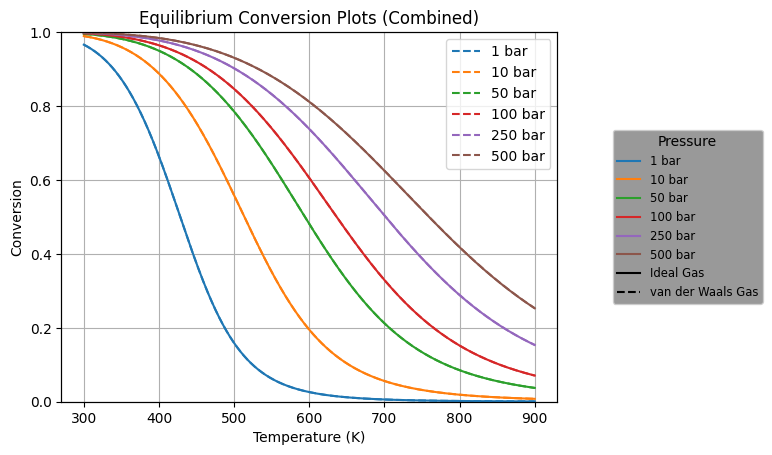

In [17]:
id = df_ideal.plot(
    ylabel="Conversion", 
    xlabel="Temperature (K)",
    title="Equilibrium Conversion Plots (Combined)",
    label=["1 bar (real)", "10 bar", "50 bar", "100 bar", "250 bar", "500 bar"],
    grid=True
)

ax2 = id.twinx()

df_real.plot(
    linestyle="--",
    color=["C0", "C1", "C2", "C3", "C4", "C5"],
    label="",
    ax=ax2
)

line = id.plot([], [], label="Ideal Gas", color="black")
dashed = id.plot([], [], label="van der Waals Gas", color="black", linestyle="--")
curves = [line[0], dashed[0]]
labels = [curve.get_label() for curve in curves]

id.set_ylim([0,1])
ax2.set_ylim([0,1])
ax2.set_yticks([]) 

id.legend(title="Pressure", fancybox=True, fontsize='small', facecolor="gray", loc='center left', bbox_to_anchor=(1.1, 0.5));

<Axes: title={'center': 'b) Conversion Plot (van der Waals)'}>

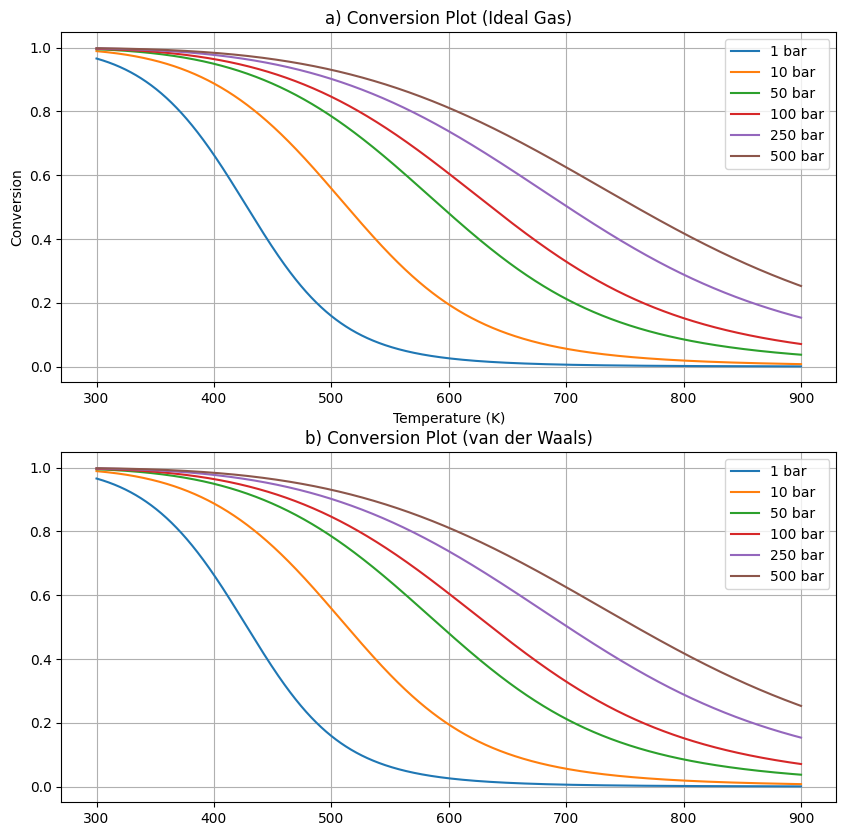

In [18]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
df_ideal.plot(
    ylabel="Conversion", 
    xlabel="Temperature (K)",
    label=["1 bar (real)", "10 bar", "50 bar", "100 bar", "250 bar", "500 bar"],
    title= "a) Conversion Plot (Ideal Gas)",
    grid=True,
    ax = ax[0]
)
df_real.plot(
    label="",
    title = "b) Conversion Plot (van der Waals)",
    grid=True,
    ax=ax[1]
)

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\abhir\AppData\Local\Temp\ipykernel_13176\1142650106.py:4: SyntaxWarning: invalid escape sequence '\D'
  ylabel="$\Delta x$",


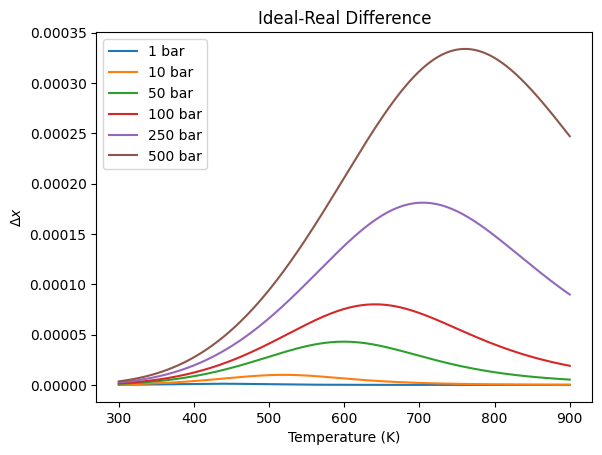

In [19]:
df_diff = df_real - df_ideal
df_diff.plot(
    xlabel="Temperature (K)",
    ylabel="$\Delta x$",
    title = "Ideal-Real Difference"
);

In [20]:
print(f"Industrial conversion (Real Gas): {df_real.loc[450, "250 bar"]}")
print(f"Industrial conversion (Ideal Gas): {df_ideal.loc[450, "250 bar"]}")

Industrial conversion (Real Gas): 0.9492943493100477
Industrial conversion (Ideal Gas): 0.949255752602826
